In [56]:
#%pip install torch --user
import json
import os
import numpy as np 
import pandas as pd
import torch
import torch.functional as F
import torch.nn as nn

%pip install transformers --user
%pip install openpyxl --user

from transformers import BertTokenizerFast,  BatchEncoding, BertModel, \
                            BertForTokenClassification
from tokenizers import Encoding

# %pip install ipywidgets --upgrade
# %pip install jupyter --upgrade
# %pip install seaborn --user
# %pip install sentencepiece

import seaborn as sns 
import matplotlib.pyplot as plt

import tqdm

from sklearn.preprocessing import LabelEncoder


torch.manual_seed(42)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [57]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/auto/brno2/home/xstary1/brno6/tumai-makeathon22/research/michal


In [58]:
import pandas as pd
from utils import preproc
df = pd.read_excel("data/appliedAI_Use Case Library - Risk Class_TUM.ai.xlsx", index_col=0, header=2)

df = preproc(df)

df_gen = pd.read_csv("data/generated_ideas (2).csv")
df_gen["description"] = df_gen["description"].apply(lambda x: x.strip())

lb = LabelEncoder()
lb.fit(df_gen["tags"].to_list() + ["high-risk", "low-risk"])

LabelEncoder()

In [59]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df, df['risk'],
#                                                     stratify=df['risk'], 
#                                                     test_size=0.2,
#                                                    random_state=42)

X_test = df
y_test = df['risk']

In [60]:
y_test

Use Case ID
1       low-risk
2      high-risk
3      high-risk
4      high-risk
5      high-risk
         ...    
114     low-risk
116     low-risk
117     low-risk
118     low-risk
119     low-risk
Name: risk, Length: 98, dtype: object

In [61]:
from torch.utils.data import Dataset

# create a dataset - currently all files loaded beforehand (woeks for smaller datasets)
class RDataset(Dataset):
    # A pytorch dataset class for holding data for a text labeling task.
    # gets a parent directory of several datasets' directories
    def __init__(self, model_name, X, y, lb):
        '''
        Takes as input the name of a file containing sentences with a classification label (comma separated) in each line.
        Stores the text data in a member variable X and labels in y
        '''
        
        # Load a pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name) 

        self.encodings = self.tokenizer(X, return_tensors="pt", padding=True)
        
        
        
        self.y = lb.transform(y)#.replace({"low-risk": 0.0, "high-risk": 1.0}).to_list()
        
        

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.y[idx])
        return item

    def __len__(self):
        return len(self.y)


In [62]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


train_gen = df_gen["description"].to_list()
train_gen_y = df_gen["tags"].to_list()

model_name = "MoritzLaurer/DeBERTa-v3-xsmall-mnli-fever-anli-ling-binary"
dataset_train = RDataset(model_name,  train_gen, train_gen_y, lb)
dataset_test = RDataset(model_name, X_test["desc"].to_list(), y_test.to_list() , lb)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_gen["tags"].unique())+2, ignore_mismatched_sizes=True)
# model.config.num_labels = 1


# freeze layers:
for name, param in model.named_parameters():
     if name.startswith("deberta"): # choose whatever you like here
        param.requires_grad = False
#         print(name)


/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/DeBERTa-v3-xsmall-mnli-fever-anli-ling-binary and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 384]) in the checkpoint and torch.Size([26, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([26]) in the model instantiated
You shoul

In [63]:
y_train

tensor([ 3,  5,  4, 20,  3, 18, 20, 10, 16, 13,  8, 23, 21, 10,  1, 16, 17, 14,
        16, 24, 10, 11, 10, 14, 25, 24, 20, 19, 22, 21,  3,  1, 13, 20, 22, 20,
        16, 17, 11, 16,  7, 23,  4, 25, 20, 19,  5,  9, 18,  5,  6, 20,  6, 17,
         6, 11, 14,  8, 13, 24, 16, 21,  3, 16, 25, 11,  2, 22,  3, 18, 14, 17,
        13, 23,  9, 23,  3, 19, 16,  8, 25, 14,  1, 11,  3,  1,  4,  5,  6, 17,
         8,  5, 22,  0, 14,  9,  3, 17,  2, 25,  2, 22, 16, 25,  9,  6,  1, 17,
         3,  7, 25, 19,  2, 24,  8,  8, 17,  3,  8,  0, 21, 25, 13,  9,  4,  0,
         5, 13, 19, 19, 22,  6, 22, 24,  6,  6, 17, 17, 22, 16,  1,  2, 21,  1,
        14, 22,  8,  1,  3,  2,  6,  1,  1, 14, 22, 19,  2, 14, 13, 14, 10,  2,
         2, 22,  7, 20, 13, 16,  3, 10, 19,  6,  7, 21, 21, 14,  0, 10,  2, 22,
         1, 17,  1,  3, 21,  0, 20, 13, 19, 24,  2,  9,  1,  4,  0, 13, 21, 10,
         5,  7, 16, 20,  6, 17, 23,  1, 21,  5,  0, 23, 17,  8,  6,  1,  4,  9,
         5,  2,  8, 24, 18, 10,  5,  3, 

In [64]:
from torch.utils.data import DataLoader



In [65]:
# Check PyTorch GPU capabilities:

print("\nPyTorch:")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('%d GPU(s) available.' % torch.cuda.device_count())
    print('GPU-Name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# device = torch.device("cpu")

model = model.to(device)


PyTorch:
1 GPU(s) available.
GPU-Name: NVIDIA A40


In [66]:
#
## other training parameters
clip = 0.25            #gradient clipping
lr = 0.0001#0.00003           #initial learning rate
wdecay=1.2e-6          #weight decay applied to all weights
epochs = 2             #maximum number of epochs
#save = 'models/model.pt'      #path to save the final model

train_max_number_batches = -1 # only for the sake of debugging. Set to -1 to be ignored
inference_max_number_batches = -1 # only for the sake of debugging. Set to -1 to be ignored

## log parameters
log_interval = 100     #log interval during training
log_interval_val = 100 #log interval during validation

In [67]:

class Learner():
    def __init__(self,train_loader, val_loader, model, optimizer, device, loss_fn=None):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        for b, inp in tqdm.tqdm(enumerate(loader), total=len(loader), position=0, leave=True):
            with torch.no_grad():
                inp = {k:v.clone().detach().to(device) for (k,v) in inp.items()}
                
                output = self.model(**inp)
                #loss = self.loss_fn(log_pred, y)
#                 logits = output.logits
                loss = output.loss
#                 loss = self.loss_fn(logits, inp["labels"], pos_weight=torch.tensor(9))
                
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, train_losses, val_losses, early_stopping=True, es_limit=3):

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        for e in range(n_epochs):
            # train
            train_loss = 0
            self.model.train()
            for b, inp in tqdm.tqdm(enumerate(self.train_loader), total=len(self.train_loader), position=0, leave=True):
                inp = {k:v.clone().detach().to(device) for (k,v) in inp.items()}

                self.optimizer.zero_grad()
                output = self.model(**inp)

                loss = output.loss

#                 print(inp["labels"])
#                 loss = self.loss_fn(logits, inp["labels"], pos_weight=torch.tensor(10))

                loss.backward()

                self.optimizer.step()

            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, "models/deberta")
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > es_limit:
                print("Early stopped")
                self.model = torch.load("models/deberta")
                break
            
            print(f"After {e+1} epochs: ")
            print(f"Train loss: {train_loss:.3}")
            print(f"Val loss: {val_loss:.3}\n")
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        return train_losses, val_losses
    
    
    
# sample 
    
batch_size = 16
a = lb.transform(train_gen_y)
unique, counts = np.unique(a, return_counts=True)
unique, counts

class_sample_count = np.zeros(max(unique)+1)
for u,c in zip(unique, counts):
    class_sample_count[u] = c
    
class_sample_count += 1

weights = 1 / torch.Tensor(class_sample_count)
samples_weight = np.array([weights[t] for t in a])
samples_weight=torch.from_numpy(samples_weight)

sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle=False, sampler = sampler)

# train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True, num_workers=0)

optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wdecay)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

train_losses, val_losses = [], []

In [75]:
learner = Learner(train_loader, val_loader, model, optim, device, loss_fn=loss_fn)
train_losses, val_losses = learner.train(10, train_losses, val_losses)

  0%|          | 0/27 [00:00<?, ?it/s]/var/tmp/pbs.12922055.meta-pbs.metacentrum.cz/ipykernel_422314/4205082293.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_scores = torch.bmm(query_layer, key_layer.transpose(-1, -2)) / torch.tensor(
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/transformers/models/deberta_v2/modeling_deberta_v2.py:829: UserWarning: To copy construct from a tensor, it i

After 1 epochs: 
Train loss: 3.08
Val loss: 3.08



 11%|█         | 3/27 [00:00<00:01, 22.25it/s]

After 2 epochs: 
Train loss: 3.09
Val loss: 3.06



 11%|█         | 3/27 [00:00<00:01, 22.26it/s]

After 3 epochs: 
Train loss: 3.06
Val loss: 3.05



 11%|█         | 3/27 [00:00<00:01, 22.42it/s]

After 4 epochs: 
Train loss: 3.02
Val loss: 3.03



 11%|█         | 3/27 [00:00<00:01, 22.47it/s]

After 5 epochs: 
Train loss: 3.02
Val loss: 3.02



 11%|█         | 3/27 [00:00<00:01, 22.21it/s]

After 6 epochs: 
Train loss: 3.01
Val loss: 3.01



 11%|█         | 3/27 [00:00<00:01, 22.29it/s]

After 7 epochs: 
Train loss: 3.0
Val loss: 3.0



 11%|█         | 3/27 [00:00<00:01, 22.81it/s]

After 8 epochs: 
Train loss: 2.99
Val loss: 3.0



 11%|█         | 3/27 [00:00<00:01, 21.79it/s]

After 9 epochs: 
Train loss: 3.01
Val loss: 2.98



100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


After 10 epochs: 
Train loss: 2.97
Val loss: 2.97



In [76]:
def predict(model, loader, device="cpu", verbose=False):
    model.eval()
    model.to(device)
    
    y_pred = []
    y_true = []
    
    for b, inp in tqdm.tqdm(enumerate(loader), total=len(loader), position=0, leave=True):
        with torch.no_grad():
            inp = {k:v.to(device) for (k,v) in inp.items()}    
            output = model(**inp)
            
        y_true.append(inp["labels"])
#         print(inp["labels"])
        #print(amask)
#         print(output.logits)
        y_pred.append(output.logits.argmax(dim=-1))
    #print(len(y_pred))
    #print(y_pred[0].shape)
    return torch.cat(y_pred, dim=0).to("cpu"), torch.cat(y_true, dim=0).to("cpu") 

pred_train, y_train = predict(model, train_loader, device=device, verbose=False)
# pred_val, y_val = predict(model, val_loader, device=device, verbose=False)
pred_test, y_test = predict(model, test_loader, device=device, verbose=False)

  0%|          | 0/27 [00:00<?, ?it/s]/var/tmp/pbs.12922055.meta-pbs.metacentrum.cz/ipykernel_422314/4205082293.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


In [77]:
y_train, y_test



(tensor([18, 25, 10, 21, 20, 16, 14, 19,  1,  1, 25,  5, 18, 11, 22,  7,  3,  3,
         25,  2, 23, 14,  4, 16, 17,  0, 13,  6, 10, 25,  6,  5,  7, 19,  9, 19,
         16, 22,  6,  4,  7, 19,  6,  9, 11, 14, 17, 11, 23, 19,  2,  2, 25, 18,
          9, 20,  9, 25, 21, 20, 18,  1, 13,  5, 25, 23, 17, 22,  2, 19,  1, 25,
          3,  8,  2,  4,  2, 17, 16, 22,  0,  9, 18,  3,  2, 21, 17, 17,  8, 23,
         20,  1,  8, 22, 17, 20,  2,  4, 17,  8,  5, 13, 14,  0, 18,  9,  6,  7,
          0,  9,  8,  0, 13,  0, 22, 21, 24,  5,  2, 13, 21,  0, 25, 25, 22, 13,
         19, 23, 22, 21, 14, 24, 23, 17,  7, 20,  8, 13,  0, 14, 13, 18,  9, 22,
         20, 19,  2, 23,  8,  5, 23,  6,  4, 22,  6,  6,  1, 24,  4, 11,  5, 24,
         17, 17,  1, 23, 14,  2, 21, 16, 13,  2, 20,  5, 14, 22,  4, 25,  7, 11,
         14, 10, 11,  2, 23, 16, 21,  7,  2, 25,  8,  9,  3, 17, 25, 25, 11,  1,
          5, 24, 23,  8, 23, 20, 10, 18, 23, 24,  9,  9,  8,  5, 22,  1,  3,  7,
          4, 14, 24,  0, 18,

In [78]:
pred_train

tensor([ 1,  5,  5,  5,  5, 17, 14,  5,  5,  0,  1,  5,  5, 11, 10, 17, 17,  4,
         5, 24,  5,  5, 24, 23, 25, 17, 24,  5,  5, 24, 10, 11,  5, 24, 17,  5,
        10,  1,  9, 17,  5, 17,  5,  3, 11, 17, 17, 11, 17,  5,  5,  5,  5, 17,
        17,  5,  5,  1, 23,  5, 23,  1,  5,  5, 17,  1, 11,  5,  2, 19,  5,  5,
        10,  0,  1, 17,  1, 17, 24, 17,  6,  3, 11, 24,  5,  5, 17,  5, 24,  5,
        17,  1,  1, 24,  5, 25, 17, 24,  5, 24,  5,  1,  5,  5,  5, 24,  9,  1,
        17,  3, 17,  6, 17, 17,  1,  1, 17,  5,  5,  5,  5, 24,  5,  5, 22,  1,
        19, 17, 17, 17,  5, 23, 17, 23,  0, 10,  1, 17,  5,  5, 14,  5, 24, 11,
        10,  5,  5,  5, 24,  5,  5, 22,  4, 16, 22,  5,  1, 24, 23, 25,  5,  5,
        24, 17,  0, 23,  0,  5,  1,  2,  5,  5, 24,  5, 17, 22, 11, 17, 17, 11,
         3,  5, 23,  5,  5, 23, 20, 24, 25, 25, 11, 23, 17, 25,  5,  1, 11,  1,
         5,  5,  5, 22, 23,  5, 10,  0, 23,  5,  5,  5,  1,  5, 17,  1,  5, 17,
        20,  5, 24, 24,  5,  5,  5,  5, 

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2148: UserWarning: labels size, 25, does not match size of target_names, 26
  warnings.warn(
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classificat

Summary on TRAIN set:

                                       precision    recall  f1-score   support

            access to self-employment       0.00      0.00      0.00        23
             biometric identification       0.31      0.70      0.43        20
            border control management       0.33      0.05      0.08        22
             categorisation of people       0.00      0.00      0.00        13
                     counting ballets       0.67      0.14      0.24        14
                       counting votes       0.13      0.77      0.22        26
                       credit scoring       0.00      0.00      0.00        17
   decision process in law facilities       0.00      0.00      0.00        15
                 democratic processes       0.00      0.00      0.00        16
            education test evaluation       0.00      0.00      0.00        18
       help with asylum legal process       0.15      0.22      0.18         9
    help with migration lega

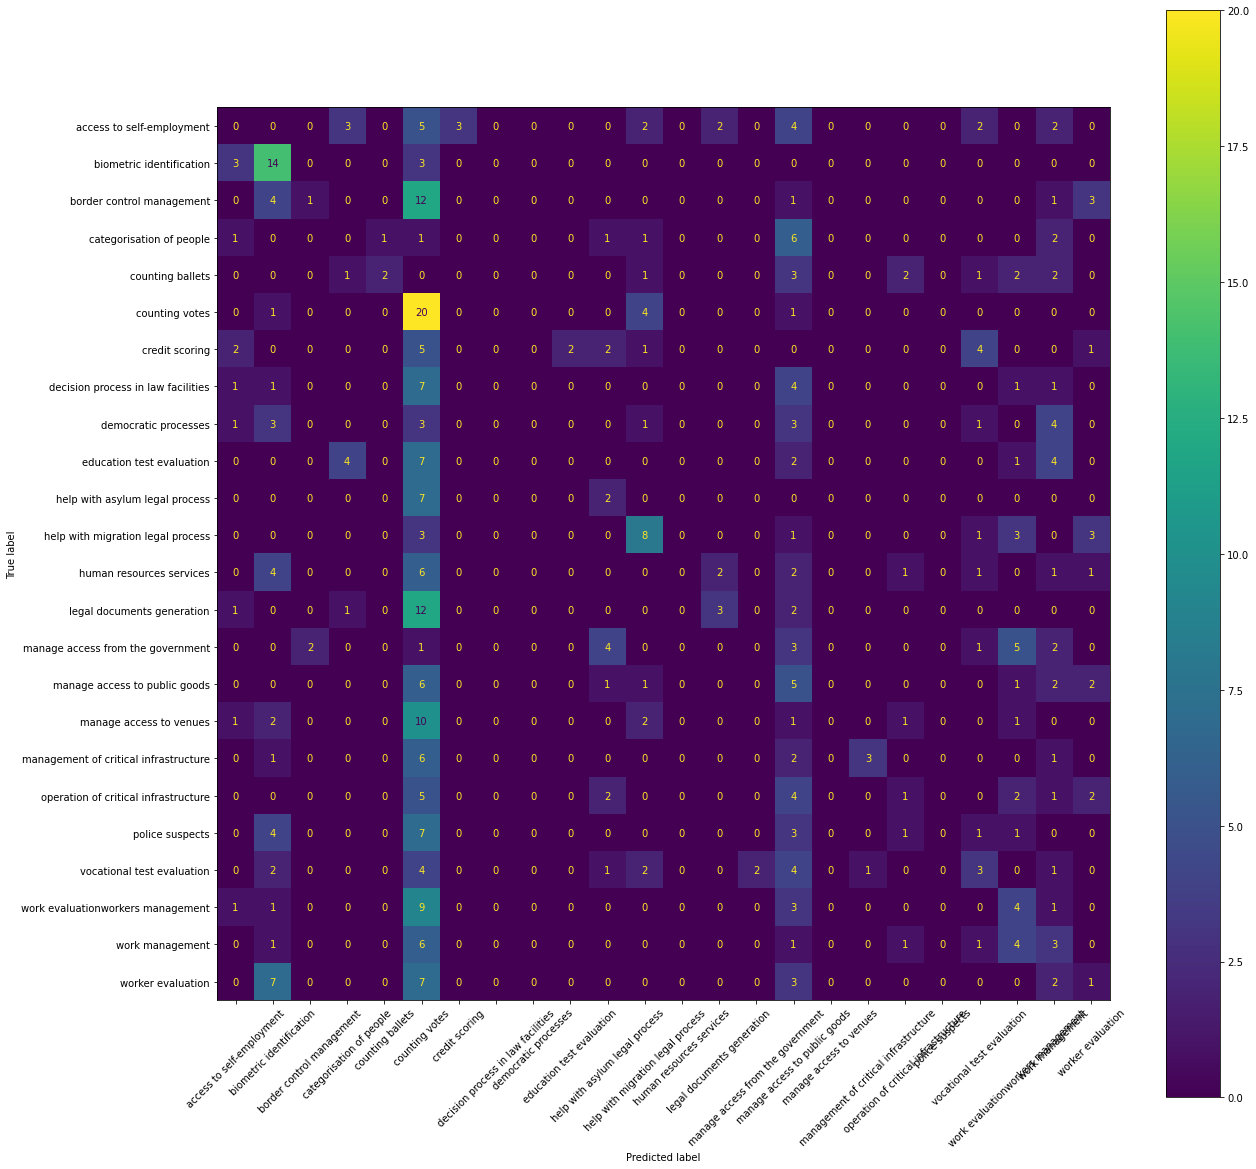

*****************************************************

Summary on TEST set:

                                       precision    recall  f1-score   support

            access to self-employment       0.00      0.00      0.00       0.0
             biometric identification       0.00      0.00      0.00       0.0
            border control management       0.00      0.00      0.00       0.0
             categorisation of people       0.00      0.00      0.00       0.0
                     counting ballets       0.00      0.00      0.00       0.0
                       counting votes       0.00      0.00      0.00       0.0
                       credit scoring       0.00      0.00      0.00       0.0
   decision process in law facilities       0.00      0.00      0.00       0.0
                 democratic processes       0.00      0.00      0.00       0.0
            education test evaluation       0.00      0.00      0.00       0.0
       help with asylum legal process       0.00     

/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2148: UserWarning: labels size, 25, does not match size of target_names, 26
  warnings.warn(
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/brno2/home/xstary1/brno6/.local-adv.SIF/lib/python3.8/site-packages/sklearn/metrics/_classificat

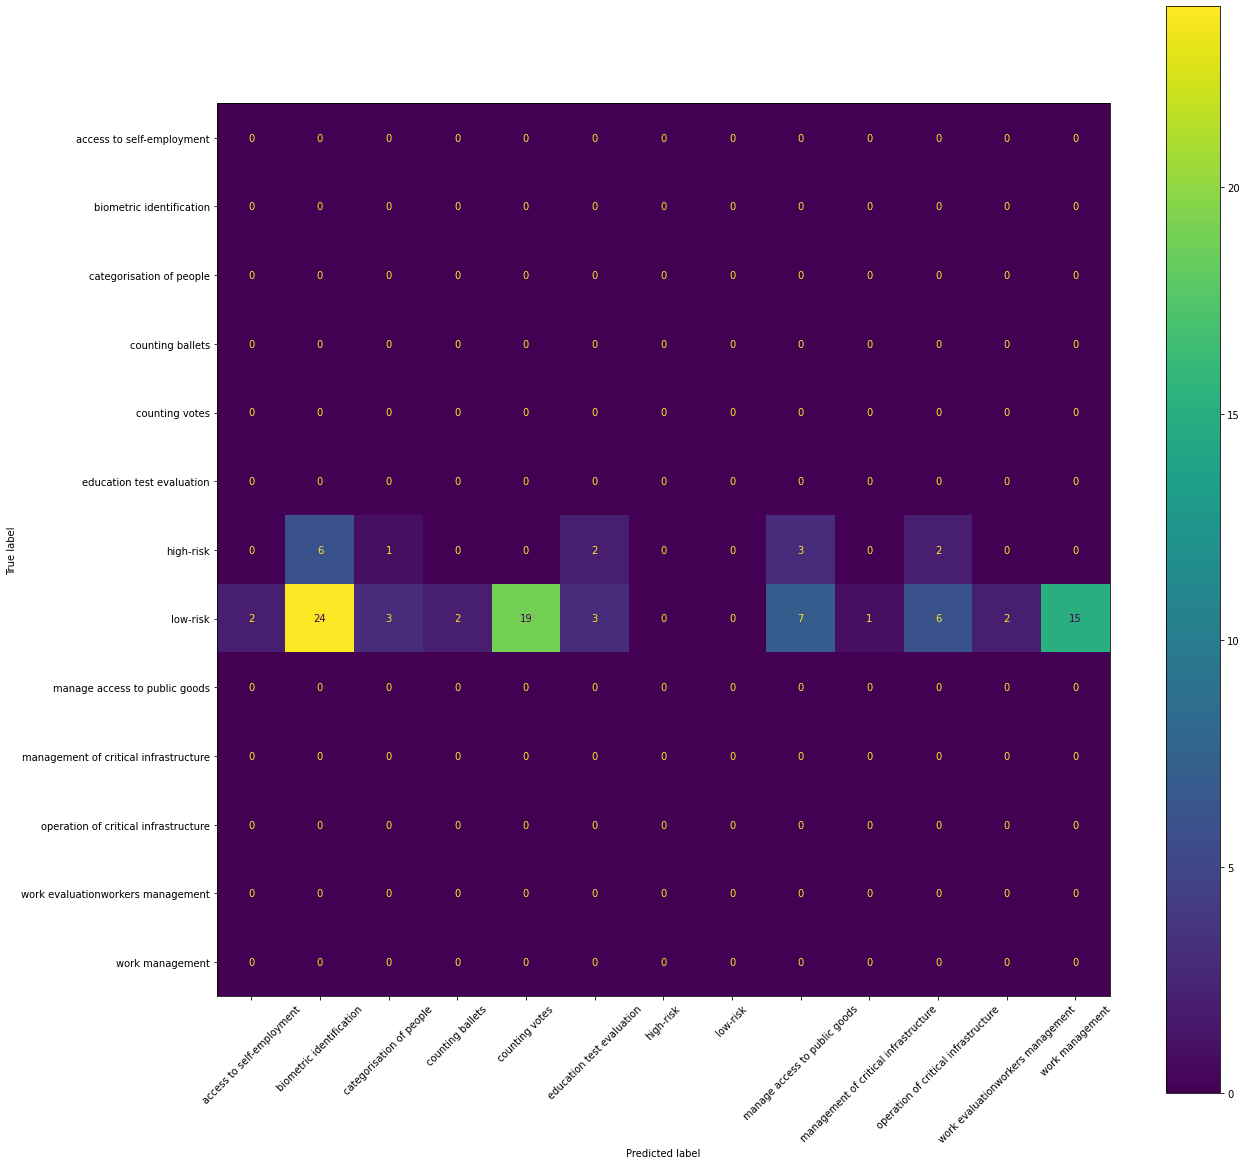

*****************************************************



In [80]:
for name, pred, y in zip(["TRAIN", "TEST"], [pred_train, pred_test], [y_train, y_test]):
    print(f"Summary on {name} set:")
    print()
    print(classification_report(y.ravel(), pred.ravel(), labels=np.arange(0,25), target_names=lb.classes_))
    print(confusion_matrix(y.ravel(), pred.ravel()))
    
    fig, ax = plt.subplots(figsize=(20,20))
    ConfusionMatrixDisplay.from_predictions(lb.inverse_transform(y.ravel()), lb.inverse_transform(pred.ravel()), labels=None, ax=ax)
    plt.xticks(rotation = 45)
    plt.show()
    print("*"*53)
    print()